1.   LIBRERIAS

# 📊 Importación de librerías principales

En esta sección se importan las librerías necesarias para el análisis de datos, visualización, preprocesamiento y modelado estadístico.  
Cada módulo cumple una función específica dentro del flujo de trabajo de Machine Learning y análisis exploratorio.



In [ ]:
import pandas as pd, glob
import numpy as np
import matplotlib.pyplot as plt
import gc
import seaborn as sns
import matplotlib.patheffects as pe
from matplotlib.patches import Ellipse
from matplotlib.ticker import FuncFormatter, PercentFormatter
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score, adjusted_rand_score, balanced_accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, precision_recall_curve, roc_auc_score, silhouette_score
from matplotlib.lines import Line2D
from scipy.stats import chi2
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

2. CONEXIÓN Y LECTURA DEL DATASET UNIFICADO

# 📂 Carga y preparación de los datos

En esta sección se:
1. Monta Google Drive para acceder a los archivos almacenados en la nube.  
2. Cargan múltiples archivos `.csv` desde una carpeta con nombre que contiene espacios.  
3. Se leen los datos en **bloques (chunks)** para evitar sobrecargar la memoria.  
4. Se limitan las filas totales a `N` registros, ajustable según la capacidad de RAM.  
5. Finalmente, se concatenan todos los fragmentos en un único `DataFrame` y se mezclan aleatoriamente.


In [ ]:
drive.mount('/content/drive')

# Ruta con espacio en "My Drive"
archivos = glob.glob("/content/drive/My Drive/TallerInt/*.csv")

# ================== PARÁMETROS ==================
N = 200_000        # súbelo a 200_000 o 700_000 si tu RAM aguanta
CHUNK = 100_000    # tamaño de lectura por partes
SEED = 42
# ================================================

dfs = []
total = 0

for f in archivos:
    # leer por chunks para no cargar todo en RAM
    for part in pd.read_csv(f, dtype=str, low_memory=False, chunksize=CHUNK):
        faltan = N - total
        if faltan <= 0:
            break
        # toma solo lo que falta para llegar a N
        piece = part.iloc[:min(faltan, len(part))].copy()
        dfs.append(piece)
        total += len(piece)
    if total >= N:
        break

# unir todo
df = pd.concat(dfs, ignore_index=True)

# Mezclar aleatoriamente para no sesgar por archivo/orden
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

# ver tamaño y memoria usada
mem_gb = df.memory_usage(deep=True).sum() / (1024**3)
print(f"Filas: {len(df):,}  Columnas: {df.shape[1]}  Memoria aprox: {mem_gb:.2f} GB")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filas: 200,000  Columnas: 107  Memoria aprox: 0.78 GB


3. VISUALIZACIÓN INICIAL (cantidad de datos y tabla)

In [ ]:
print("Dimensión del dataset:", df.shape)
df.head()

Dimensión del dataset: (200000, 107)


,semestre,sede,estructura,curricula,curso,seccion,modalidad,version,fecha,usuarioregistro,...,estado,tardanza,justificacion,sesionesagrupadas,fechaeliminafalta,usuarioeliminafalta,grupo,semana,item,estructuraalumno
0,20192,01,094,02,NaN,NaN,S,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20062,01,031,01,NaN,NaN,P,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20212,02,541,01,NaN,NaN,P,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20171,01,046,03,NaN,NaN,P,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,093,02,NaN,NaN,S,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4. VISUALIZACIÓN DE NULOS (antes de limpiar)

In [ ]:
print("Nulos por columna:")
print(df.isnull().sum())

df.isnull().head()

Nulos por columna:
semestre                37876
sede                    37876
estructura                161
curricula                 161
curso                  160053
                        ...  
usuarioeliminafalta    200000
grupo                  200000
semana                 173033
item                   173033
estructuraalumno       173357
Length: 107, dtype: int64


,semestre,sede,estructura,curricula,curso,seccion,modalidad,version,fecha,usuarioregistro,...,estado,tardanza,justificacion,sesionesagrupadas,fechaeliminafalta,usuarioeliminafalta,grupo,semana,item,estructuraalumno
0,False,False,False,False,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,False,False,False,False,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,True,True,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,False,False,True,True,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True


*   **HISTORIA DE USUARIO 02**

5. LIMPIEZA (duplicados y nulos)

In [ ]:
pd.set_option('future.no_silent_downcasting', True)

print("Duplicados antes:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
df = df.ffill().bfill()
df = df.infer_objects(copy=False)
print("Duplicados después:", df.duplicated().sum())
print("Nulos después:", int(df.isnull().sum().sum()))

Duplicados antes: 6490
Duplicados después: 1
Nulos después: 1161060


In [ ]:
pd.set_option('future.no_silent_downcasting', True)

# 1) Normaliza marcadores vacíos
df = df.replace(["", " ", "NA", "N/A", "NaN", "nan", "NULL", "null", "--"], np.nan)

# 2) Quita columnas casi vacías (>=95% nulas) y filas totalmente nulas
df = df.dropna(axis=1, thresh=int(len(df)*0.05))
df = df.dropna(how="all")

# 3) Convierte a numéricas solo columnas "parecidas a número"
num_like = []
for c in df.columns:
    if df[c].dtype == "object":
        s = df[c].astype(str).str.replace(",", ".", regex=False).str.replace(" ", "", regex=False)
        if s.str.match(r"^-?\d+(\.\d+)?$|^-?\d{1,3}(?:\.\d{3})+(?:,\d+)?$").any():
            num_like.append(c)
for c in num_like:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ".", regex=False), errors="coerce")

# 4) Tipos y listas de columnas
num_cols  = df.select_dtypes(include="number").columns
date_cols = df.select_dtypes(include=["datetime64[ns]", "datetime64[ns, UTC]"]).columns
obj_cols  = [c for c in df.columns if c not in num_cols and c not in date_cols]

# 5) Imputación
if len(num_cols) > 0:
    df[num_cols] = df[num_cols].apply(lambda s: s.fillna(s.median()))
for c in date_cols:
    if df[c].isna().any():
        df[c] = df[c].ffill().bfill()
for c in obj_cols:
    if df[c].isna().any():
        m = df[c].mode(dropna=True)
        df[c] = df[c].fillna(m.iloc[0] if not m.empty else "desconocido")

# 6) Elimina residuales, si quedaran
if df.isna().sum().sum() > 0:
    df = df.dropna()

print("Nulos restantes:", int(df.isna().sum().sum()))

# 7) Filtrar columnas numéricas con demasiados ceros (proporción + mínimo absoluto)
num = df.select_dtypes(include="number").copy()

min_frac_nonzero = 0.20     # ≥20% valores != 0
min_abs_nonzero  = 50_000  # ≥100,000 valores != 0

n = len(num)
nonzero      = (num != 0).sum()
frac_nonzero = nonzero / n

mask_drop = (frac_nonzero < min_frac_nonzero) | (nonzero < min_abs_nonzero)
cols_drop = mask_drop[mask_drop].index.tolist()

print(f"Filas: {n}")
print("Columnas a eliminar por demasiados ceros:", cols_drop)

# 8) SOBREESCRIBIR el DataFrame ORIGINAL
df = df.drop(columns=cols_drop, errors="ignore").copy()
print("Shape final df:", df.shape)

Nulos restantes: 0
Filas: 193510
Columnas a eliminar por demasiados ceros: ['version', 'observacion', 'creditoselectivoaprobado', 'creditosfueraplanaprobado', 'creditosobligatorios', 'creditoselectivos', 'creditosfueraplan', 'promediohistorico', 'promedioevolutivo', 'promediosemestreanterior', 'resolucion', 'promedioponderadototal', 'quintaglobal', 'quintaestructura', 'decimaestructura', 'terciaciclo', 'quintaciclo', 'tardanza']
Shape final df: (193510, 83)


6. VISUALIZACIÓN DE LOS DATOS ELIMINADOS

In [ ]:
print(df.isnull().sum())

semestre             0
sede                 0
estructura           0
curricula            0
curso                0
                    ..
justificacion        0
sesionesagrupadas    0
semana               0
item                 0
estructuraalumno     0
Length: 83, dtype: int64


*   **HISTORIA DE USUARIO 03**

7. MEDIDAS ESTADÍSTICAS

In [ ]:
# Seleccionar solo columnas numéricas
num_cols = df.select_dtypes(include=np.number).columns
print("Columnas numéricas:", list(num_cols))

# Descripción estadística
desc = df[num_cols].describe(percentiles=[.25,.5,.75]).T

# Agregar moda
desc["moda"] = [df[c].mode().iloc[0] if not df[c].mode().empty else np.nan for c in num_cols]
desc

Columnas numéricas: ['semestre', 'sede', 'estructura', 'curricula', 'curso', 'usuarioregistro', 'usuariomodifica', 'persona', 'alumno', 'usuario', 'ciclomatriculado', 'condicionalumnomatriculado', 'semestreanterior', 'ciclo', 'cicloactual', 'creditosmatriculado', 'creditosobligatoriosaprobado', 'promedioponderado', 'promediosemestre', 'cerrado', 'tipodocumento', 'condicionalumno', 'cursosaprobados', 'cursosmatriculados', 'ordenmeritoglobal', 'terciaglobal', 'mediaglobal', 'ordenmeritoesstructura', 'terciaestructura', 'mediaestructura', 'ordenmeritociclo', 'mediaciclo', 'cicloNew', 'creditosaprobadostotal', 'maxcreditosmatricula', 'usuario_cursos', 'usuario_creditos', 'usuario_ciclo', 'usuario_ponderado', 'usuario_ponderadoacum', 'usuario_condicion', 'usuario_merito', 'usuario_cierre', 'actividad', 'descripcion', 'orden', 'sistema', 'activo', 'ambiente', 'local', 'pabellon', 'capacidad', 'tipoambiente', 'usuarioedita', 'material', 'cantidad', 'sesiones', 'estado', 'justificacion', 'sesi

,count,mean,std,min,25%,50%,75%,max,moda
semestre,193510.0,20177.868787,39.493238,20011.0,20162.0,20192.0,20210.0,20221.0,20162.0
sede,193510.0,1.373913,1.590223,1.0,1.0,1.0,1.0,15.0,1.0
estructura,193510.0,187.690130,198.180266,26.0,46.0,90.0,432.0,572.0,93.0
curricula,193510.0,2.063470,1.380041,1.0,1.0,2.0,2.0,8.0,1.0
curso,193510.0,7641.046272,3455.097634,35.0,2873.0,10010.0,10025.0,11614.0,10010.0
...,...,...,...,...,...,...,...,...,...
justificacion,193510.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0,2.0
sesionesagrupadas,193510.0,7317.237073,805.273806,979.0,6771.0,7252.0,8078.0,8340.0,6872.0
semana,193510.0,8.381753,4.610470,1.0,4.0,8.0,12.0,16.0,1.0
item,193510.0,1.026035,0.159239,1.0,1.0,1.0,1.0,2.0,1.0


8. NORMALIZACIÓN

In [ ]:
df_minmax = df.copy()
df_zscore = df.copy()

for c in num_cols:
    if df[c].max() != df[c].min():
        df_minmax[c+"_minmax"] = (df[c] - df[c].min())/(df[c].max() - df[c].min())
    df_zscore[c+"_z"] = (df[c] - df[c].mean())/df[c].std(ddof=0)

print("Normalización aplicada:")
df_minmax.head(3)

Normalización aplicada:


,semestre,sede,estructura,curricula,curso,seccion,modalidad,fecha,usuarioregistro,fecharegistro,...,capacidad_minmax,tipoambiente_minmax,material_minmax,cantidad_minmax,sesiones_minmax,estado_minmax,sesionesagrupadas_minmax,semana_minmax,item_minmax,estructuraalumno_minmax
0,20192,1.0,94.0,2.0,10013.0,2A,S,2016-12-09 16:34:08,18226284.0,2019-11-21 18:04:49,...,0.010688,0.0,0.5,0.0,0.756962,1.0,0.862519,0.066667,0.0,0.302326
1,20062,1.0,31.0,1.0,10013.0,2A,P,2016-12-09 16:34:08,18226284.0,2018-12-29 11:36:04,...,0.010688,0.0,0.5,0.0,0.756962,1.0,0.862519,0.066667,0.0,0.302326
2,20212,2.0,541.0,1.0,10013.0,2A,P,2016-12-09 16:34:08,18226284.0,2021-08-15 12:03:07,...,0.010688,0.0,0.5,0.0,0.756962,1.0,0.862519,0.066667,0.0,0.302326


9. BOXPLOT

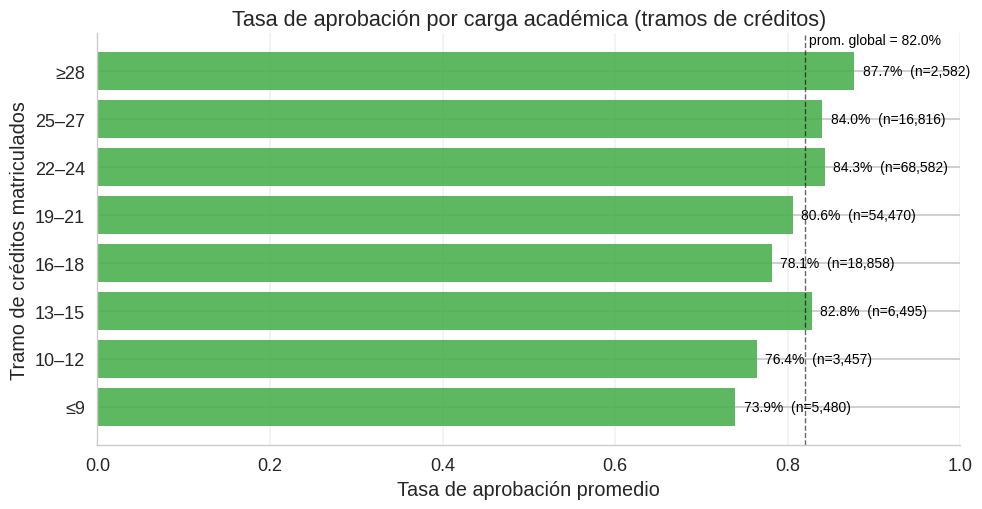

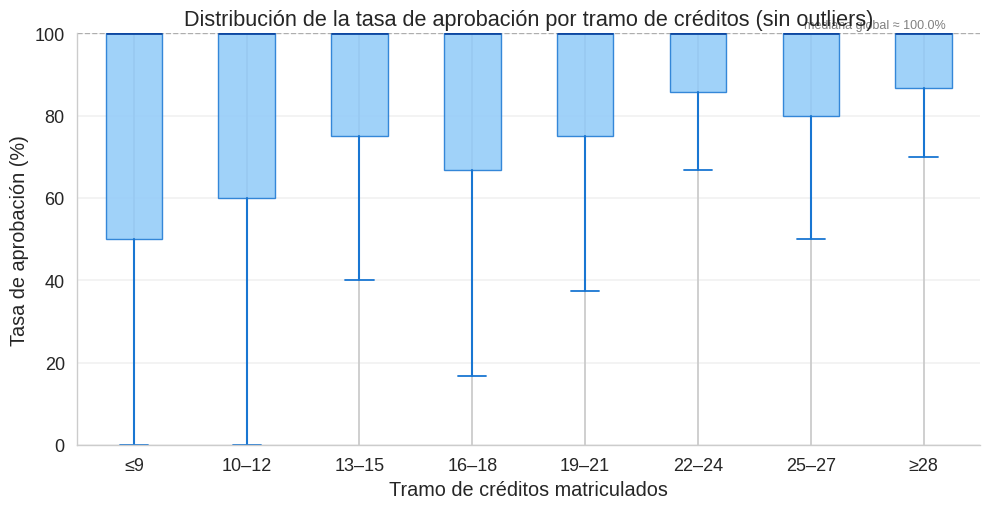

In [ ]:
# ===========================================
# Tasa de aprobación vs. carga académica (créditos)
# Gráfico A: barras (promedio por tramo + n)
# Gráfico B: boxplot (distribución de tasas por tramo, sin outliers)
# ===========================================


# --- 1) Construir tasa robusta (0..1) y tramos de créditos
t_aprob = (
    pd.to_numeric(df["cursosaprobados"], errors="coerce") /
    pd.to_numeric(df["cursosmatriculados"], errors="coerce")
).clip(0, 1)

creditos = pd.to_numeric(df["creditosmatriculado"], errors="coerce")

bins   = [0, 9, 12, 15, 18, 21, 24, 27, np.inf]
labels = ["≤9","10–12","13–15","16–18","19–21","22–24","25–27","≥28"]
bin_cred = pd.cut(creditos, bins=bins, labels=labels, include_lowest=True)

# --- 2) Promedio global (para línea de referencia)
prom_global = t_aprob.mean(skipna=True)

# --- 3) Resumen para barras (promedio y n por tramo)
res_barras = (
    pd.DataFrame({"tramo": bin_cred, "tasa": t_aprob})
      .dropna()
      .groupby("tramo", observed=False)["tasa"]  # corregido: observed=False
      .agg(mean="mean", n="size")
      .reindex(labels)
)

# --- 4) FIGURA A: Barras horizontales
fig, ax = plt.subplots(figsize=(10, 5.2))

# Escala en 0..1 (después formateamos como %)
bars = ax.barh(res_barras.index.astype(str), res_barras["mean"], color="#4CAF50", alpha=0.9)

# Línea de promedio global
ax.axvline(prom_global, color="k", lw=1, ls="--", alpha=0.6)
ax.text(
    prom_global + 0.005, len(labels) - 0.5,
    f"prom. global = {prom_global:,.1%}",
    ha="left", va="bottom", fontsize=10, color="k"
)

# Anotación de % y n en cada barra
for rect, p, n in zip(bars, res_barras["mean"], res_barras["n"]):
    ax.text(
        min(p + 0.01, 0.98), rect.get_y() + rect.get_height()/2,
        f"{p:,.1%}  (n={n:,})",
        va="center", ha="left", fontsize=10, color="black"
    )

ax.set_xlim(0, 1)
ax.set_xlabel("Tasa de aprobación promedio")
ax.set_ylabel("Tramo de créditos matriculados")
ax.set_title("Tasa de aprobación por carga académica (tramos de créditos)")
ax.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()

# --- 5) Preparar series por tramo para Boxplot
series_por_tramo = []
for lab in labels:
    serie = t_aprob[bin_cred == lab].dropna()
    # winsor suave (1–99%) para evitar colas raras pero mantener forma
    if len(serie) > 0:
        q1, q99 = serie.quantile([0.01, 0.99])
        serie = serie.clip(q1, q99)
    series_por_tramo.append(100 * serie)  # a %

# --- 6) FIGURA B: Boxplot (distribución por tramo)
fig, ax = plt.subplots(figsize=(10, 5.2))

box = ax.boxplot(
    series_por_tramo,
    tick_labels=labels,      # corregido: tick_labels (antes 'labels')
    showfliers=False,
    patch_artist=True
)

# Colorear cajas
for patch in box["boxes"]:
    patch.set(facecolor="#90CAF9", alpha=0.85, edgecolor="#1976D2")

for med in box["medians"]:
    med.set(color="#0D47A1", lw=2)

for whisk in box["whiskers"]:
    whisk.set(color="#1976D2", lw=1.5)

for cap in box["caps"]:
    cap.set(color="#1976D2", lw=1.3)

ax.set_ylim(0, 100)
ax.set_ylabel("Tasa de aprobación (%)")
ax.set_xlabel("Tramo de créditos matriculados")
ax.set_title("Distribución de la tasa de aprobación por tramo de créditos (sin outliers)")
ax.grid(axis="y", alpha=0.25)

# Línea de referencia a la mediana global (opcional)
med_global = (100 * t_aprob).median(skipna=True)
ax.axhline(med_global, color="gray", lw=1, ls="--", alpha=0.6)
ax.text(
    len(labels) + 0.2, med_global + 0.5,
    f"mediana global ≈ {med_global:,.1f}%",
    ha="right", va="bottom", fontsize=9, color="gray"
)

plt.tight_layout()
plt.show()

10. SCATTER PLOT (DISPERSIÓN)

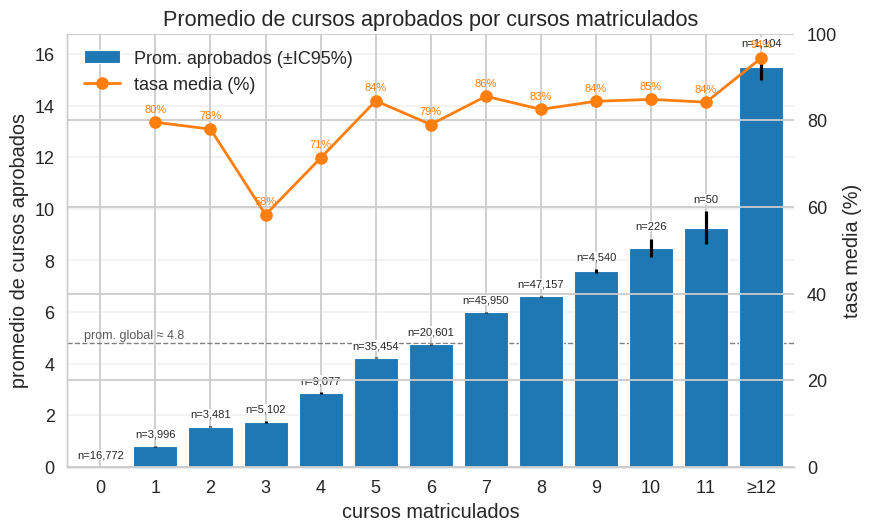

In [ ]:
# --------- datos base y limpieza ---------
x, y = "cursosmatriculados", "cursosaprobados"

d = (
    pd.DataFrame({
        x: pd.to_numeric(df[x], errors="coerce"),
        y: pd.to_numeric(df[y], errors="coerce"),
    })
    .dropna()
    .astype(int)
)

cap_x = 12  # agrupar 12+
d[x] = np.where(d[x] > cap_x, cap_x, d[x])

# tasa por registro (evita división por 0 y acota)
d["tasa"] = np.where(d[x] > 0, d[y] / d[x], np.nan).clip(0, 1)

# agregados por número de cursos matriculados
g = (
    d.groupby(x, observed=True)
     .agg(mean_aprob=(y, "mean"),
          n=(y, "count"),
          std=(y, "std"),
          tasa_mean=("tasa", "mean"))
     .reset_index()
     .sort_values(x)
)

# IC95% de la media (z≈1.96); si n<=1 no hay IC
g["ci"] = np.where(g["n"] > 1, 1.96 * (g["std"] / np.sqrt(g["n"])), np.nan)

ticks = g[x].tolist()
tick_labels = [str(t) if t < cap_x else f"≥{cap_x}" for t in ticks]

# referencia: promedio global de cursos aprobados (sobre todos los registros)
global_mean_aprob = d[y].mean()

# --------- PLOT ---------
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

fig, ax = plt.subplots(figsize=(8.6, 5.2))

# Barras con error bars (±IC95%)
bars = ax.bar(
    ticks, g["mean_aprob"],
    yerr=g["ci"], capsize=3,
    color="#1f77b4", edgecolor="white", linewidth=0.8,
    label="Prom. aprobados (±IC95%)", zorder=2
)

# Etiquetas n= con separador de miles y fondo blanco
for xi, m, ci, n in zip(ticks, g["mean_aprob"], g["ci"].fillna(0), g["n"]):
    ax.annotate(
        f"n={n:,}",
        xy=(xi, m + ci), xycoords=("data", "data"),
        xytext=(0, 5), textcoords="offset points",
        ha="center", va="bottom", fontsize=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.9, pad=0.2),
        zorder=3
    )

# Línea de referencia: promedio global de cursos aprobados
ax.axhline(global_mean_aprob, ls="--", lw=1, color="0.5", zorder=1)
ax.text(
    ticks[0] - 0.3, global_mean_aprob + 0.05,
    f"prom. global ≈ {global_mean_aprob:.1f}",
    ha="left", va="bottom", fontsize=9, color="0.35"
)

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
ax.set_xlabel("cursos matriculados")
ax.set_ylabel("promedio de cursos aprobados")
ax.set_title("Promedio de cursos aprobados por cursos matriculados")
ax.set_xlim(min(ticks) - 0.6, max(ticks) + 0.6)
ax.grid(alpha=0.25, axis="y", zorder=1)

# Eje secundario con la tasa media (%)
ax2 = ax.twinx()
ax2.plot(
    ticks, g["tasa_mean"] * 100,
    color="#ff7f0e", marker="o", lw=2, label="tasa media (%)", zorder=4
)
for xi, t in zip(ticks, g["tasa_mean"] * 100):
    ax2.annotate(
        f"{t:.0f}%",
        xy=(xi, t), xycoords=("data", "data"),
        xytext=(0, 6), textcoords="offset points",
        ha="center", va="bottom", fontsize=8, color="#ff7f0e"
    )
ax2.set_ylim(0, 100)
ax2.set_ylabel("tasa media (%)")

# Leyenda combinada
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, frameon=False, loc="upper left")

fig.set_constrained_layout(True)
plt.show()

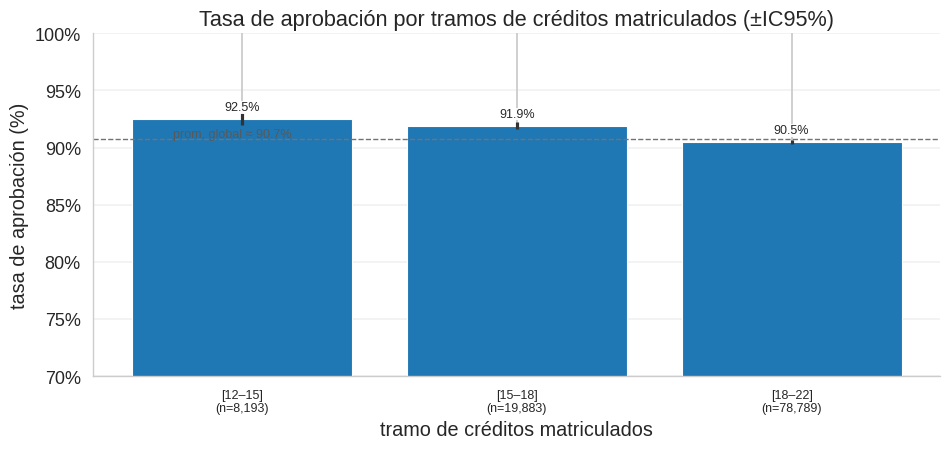

In [ ]:
# --- preparar datos (igual que antes) ---
x_raw = pd.to_numeric(df["creditosmatriculado"], errors="coerce")
y_raw = pd.to_numeric(df["creditosaprobadostotal"], errors="coerce")

d = pd.DataFrame({"mat": x_raw, "apr": y_raw}).dropna()
d = d[(d["mat"] > 0) & (d["mat"] <= 22)]          # <-- límite superior 22
d["tasa"] = (d["apr"] / d["mat"]).clip(0, 1)

# --- tramos hasta 22 ---
bins   = [12, 15, 18, 22]                         # 12–15, 15–18, 18–22
labels = ["[12–15]", "[15–18]", "[18–22]"]
# right=True incluye el límite derecho (p.ej. 22 entra en [18–22])
d["tramo"] = pd.cut(
    d["mat"], bins=bins, labels=labels,
    right=True, include_lowest=True, ordered=True
)

# --- agregados e IC95% (igual) ---
g = (d.groupby("tramo", observed=True)["tasa"]
       .agg(mean="mean", std="std", count="count")
       .reset_index()
       .dropna()
       .sort_values("tramo"))
g["se"]   = g["std"] / np.sqrt(g["count"])
g["ci95"] = np.where(g["count"] > 1, 1.96 * g["se"], np.nan)

# promedio global con el recorte aplicado (opcional)
global_mean = d["tasa"].mean() * 100

# --- gráfico (el resto igual que la versión pulida) ---
pos = np.arange(len(g))
fig, ax = plt.subplots(figsize=(9.6, 4.6))
bars = ax.bar(pos, g["mean"]*100, yerr=g["ci95"]*100, capsize=3,
              color="#1f77b4", edgecolor="white", linewidth=0.8, ecolor="#333", zorder=2)

for x, pct in zip(pos, g["mean"]*100):
    ax.annotate(f"{pct:.1f}%", (x, pct), xytext=(0, 4), textcoords="offset points",
                ha="center", va="bottom", fontsize=9,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.9, pad=0.2), zorder=3)

ax.set_xticks(pos)
ax.set_xticklabels([f"{t}\n(n={int(n):,})" for t, n in zip(g["tramo"], g["count"])], fontsize=9)

ax.axhline(global_mean, ls="--", lw=1, color="0.45")
ax.text(-0.25, global_mean + 0.2, f"prom. global ≈ {global_mean:.1f}%", color="0.35", fontsize=9)

ax.set_ylim(70, 100)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{v:.0f}%"))
ax.set_ylabel("tasa de aprobación (%)")
ax.set_xlabel("tramo de créditos matriculados")
ax.set_title("Tasa de aprobación por tramos de créditos matriculados (±IC95%)")
ax.grid(axis="y", alpha=0.25)
fig.tight_layout(); plt.show()

**Insight 1: Distribución de promedios del semestre**

**Mensaje (qué queremos que se recuerde):**
La mayoría de estudiantes se concentra en un rango “saludable” de promedio (≈13–17), con una mediana en 15; sin embargo, existe una cola baja (<11) que requiere acciones tempranas y focalizadas.

**Personajes:**

* Estudiantes de pregrado con promedio de semestre > 0.
* Unidades académicas y tutores que pueden activar apoyos.
* Gestores de éxito que diseñan intervenciones por riesgo.

**Ambiente:**
Todos los programas, último semestre cursado. Fuente: base institucional; histograma con acumulado.

**Conflicto:**
¿Cómo priorizar esfuerzos de acompañamiento cuando los casos de riesgo son pocos en proporción, pero críticos en impacto?

**Trama:**

* **Planteamiento:** Observamos la distribución de promedios del semestre y su acumulado.

* **Nudo (hallazgos con datos):**

  * Mediana ≈ 15.0: la mitad de estudiantes está en 15 o más.
  * P10 ≈ 10.8: el 10% está por debajo de ~10.8 (zona de alerta).
  * P90 ≈ 17.0: el 10% superior supera ~17.0 (alto desempeño).
  * La mayor densidad se ubica entre 13 y 17, donde el acumulado crece con mayor pendiente.
  * Existe cola baja (≤11) con menor frecuencia absoluta, pero con alto riesgo académico.

* **Desenlace (qué hacemos con esto):** Usamos los percentiles para segmentar alertas y beneficios.

**Datos clave del gráfico**

* n (>0) ≈ 352,9k estudiantes.
* Percentiles marcados: P10≈10.8 · P50≈15.0 · P90≈17.0.
* Rango de mayor concentración: 13–17.

**Implicaciones y acciones**

1. **Alerta temprana automática para promedios < P10 (≈10.8):** derivación a tutorías, revisión de carga y hábitos de estudio.

2. **Acompañamiento focalizado 13–15:** cohortes en transición al rendimiento medio-alto; micro-intervenciones (workshops, feedback dirigido).

3. **Reconocimiento y retención > P90 (≈17.0):** programas de mentoría inversa, becas de excelencia, proyectos avanzados.

4. **Planeación de cursos:** ajustar oferta de apoyos (monitores, horas de consulta) en semanas clave para el tramo 13–15.

5. **Monitoreo mensual:** trackear desplazamientos entre tramos (sube/baja respecto al P50) para medir impacto de las intervenciones.

**Nota de cautela**

- Los promedios no capturan factores contextuales (carga laboral, salud, economía). Úsalos como señal, no como diagnóstico final.

- **Evitar sesgos por carreras/planes:** comparar dentro de programa cuando se tomen decisiones individuales.

Ceros: 19,892 (10.3%) — n>0: 173,618


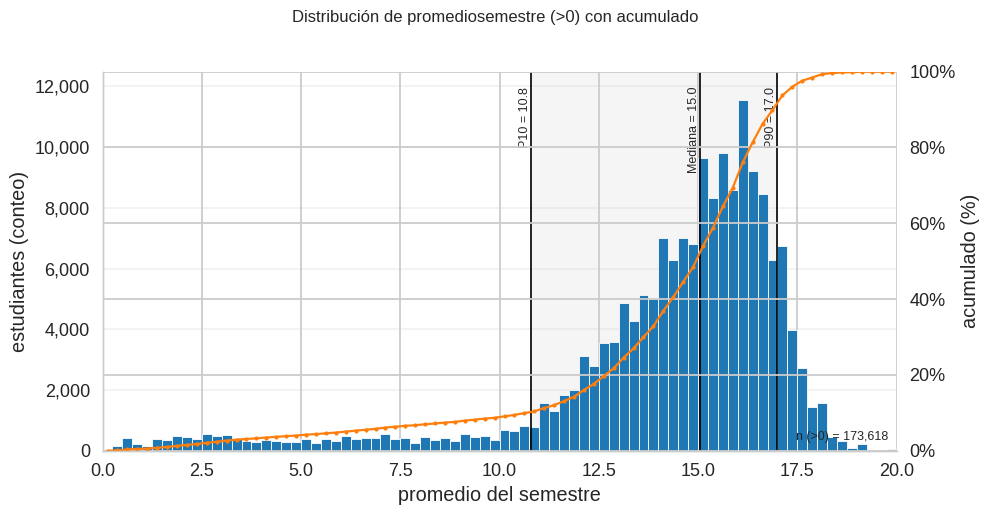

In [ ]:
# --- 1) Serie a graficar (>0) ---
col = "promediosemestre"  # cambia si necesitas otra
s_all = pd.to_numeric(df[col], errors="coerce").dropna()
s_pos = s_all[s_all > 0]

# (opcional) muestra en consola los ceros:
n_zeros = (s_all == 0).sum()
print(f"Ceros: {n_zeros:,} ({n_zeros/len(s_all):.1%}) — n>0: {len(s_pos):,}")

# --- 2) Bins “redondos” ---
step = 0.25  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<< aquí defines step
bins = np.arange(np.floor(s_pos.min()), np.ceil(s_pos.max()) + step, step)

# --- 3) Histograma + acumulado ---
counts, edges = np.histogram(s_pos, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2
cum_pct = counts.cumsum() / counts.sum() * 100

fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras
ax1.bar(
    edges[:-1], counts,
    width=np.diff(edges), align="edge",
    edgecolor="white", linewidth=0.6
)
ax1.set_xlim(edges[0], edges[-1])
ax1.set_ylim(0, counts.max()*1.08)
ax1.set_xlabel("promedio del semestre")
ax1.set_ylabel("estudiantes (conteo)")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f"{int(v):,}"))
ax1.grid(axis="y", alpha=0.25)

# Línea acumulada (%)
ax2 = ax1.twinx()
ax2.plot(centers, cum_pct, color="tab:orange", marker="o", ms=3, lw=1.6, label="acumulado (%)")
ax2.set_ylim(0, 100)
ax2.set_ylabel("acumulado (%)")
ax2.yaxis.set_major_formatter(PercentFormatter())

# Percentiles y banda P10–P90
q10, q50, q90 = np.percentile(s_pos, [10, 50, 90])
for x, lab in [(q10, f"P10 = {q10:.1f}"), (q50, f"Mediana = {q50:.1f}"), (q90, f"P90 = {q90:.1f}")]:
    ax1.axvline(x, color="k", lw=1.2)
    ax1.text(x, ax1.get_ylim()[1]*0.96, lab, rotation=90, va="top", ha="right", fontsize=9)
ax1.axvspan(q10, q90, color="grey", alpha=0.08, zorder=0)

# Nota de n
ax1.text(0.99, 0.02, f"n (>0) = {len(s_pos):,}", transform=ax1.transAxes,
         ha="right", va="bottom", fontsize=9)

fig.suptitle(f"Distribución de {col} (>0) con acumulado", y=1.02)
fig.tight_layout()
plt.show()

**Insight 2:**

In [ ]:
# Asegurarnos de que las columnas son numéricas
df['cursosmatriculados'] = pd.to_numeric(df['cursosmatriculados'], errors='coerce')
df['cursosaprobados'] = pd.to_numeric(df['cursosaprobados'], errors='coerce')
df['creditosmatriculado'] = pd.to_numeric(df['creditosmatriculado'], errors='coerce')
df['creditosaprobadostotal'] = pd.to_numeric(df['creditosaprobadostotal'], errors='coerce')

# 1. Calcular cursos y créditos desaprobados
df['cursos_desaprobados'] = df['cursosmatriculados'] - df['cursosaprobados']
df['creditos_desaprobados'] = df['creditosmatriculado'] - df['creditosaprobadostotal']

# 2. Calcular tasas de aprobación
df['tasa_aprobacion_cursos'] = (df['cursosaprobados'] / df['cursosmatriculados']).fillna(0)
df['tasa_aprobacion_creditos'] = (df['creditosaprobadostotal'] / df['creditosmatriculado']).fillna(0)

# 3. Agrupar por carrera (usando 'estructuraalumno') y calcular métricas
# Tomaremos las 10 carreras con más registros para un análisis más claro
top_carreras = df['estructuraalumno'].value_counts().nlargest(10).index

df_carreras = df[df['estructuraalumno'].isin(top_carreras)]

analisis_por_carrera = df_carreras.groupby('estructuraalumno').agg(
    tasa_aprobacion_cursos_promedio=('tasa_aprobacion_cursos', 'mean'),
    tasa_aprobacion_creditos_promedio=('tasa_aprobacion_creditos', 'mean'),
    cursos_matriculados_total=('cursosmatriculados', 'sum'),
    cursos_aprobados_total=('cursosaprobados', 'sum'),
    cursos_desaprobados_total=('cursos_desaprobados', 'sum'),
    creditos_matriculados_total=('creditosmatriculado', 'sum'),
    creditos_aprobados_total=('creditosaprobadostotal', 'sum'),
    creditos_desaprobados_total=('creditos_desaprobados', 'sum'),
    numero_de_registros=('semestre', 'count')
).reset_index()

# Ordenar por la tasa de aprobación de cursos para una mejor visualización
analisis_por_carrera = analisis_por_carrera.sort_values('tasa_aprobacion_cursos_promedio', ascending=False)

print("Análisis por Carrera:")
print(analisis_por_carrera)

Análisis por Carrera:
   estructuraalumno  tasa_aprobacion_cursos_promedio  \
0                26                              inf   
7                49                              inf   
5                43                         0.750803   
3                40                         0.750196   
4                42                         0.749689   
6                46                         0.749213   
2                39                         0.749209   
9                69                         0.748328   
1                30                         0.747480   
8                68                         0.747216   

   tasa_aprobacion_creditos_promedio  cursos_matriculados_total  \
0                                inf                     111483   
7                                inf                     390298   
5                                inf                      22704   
3                                inf                      87188   
4                         

/tmp/ipython-input-1088334925.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


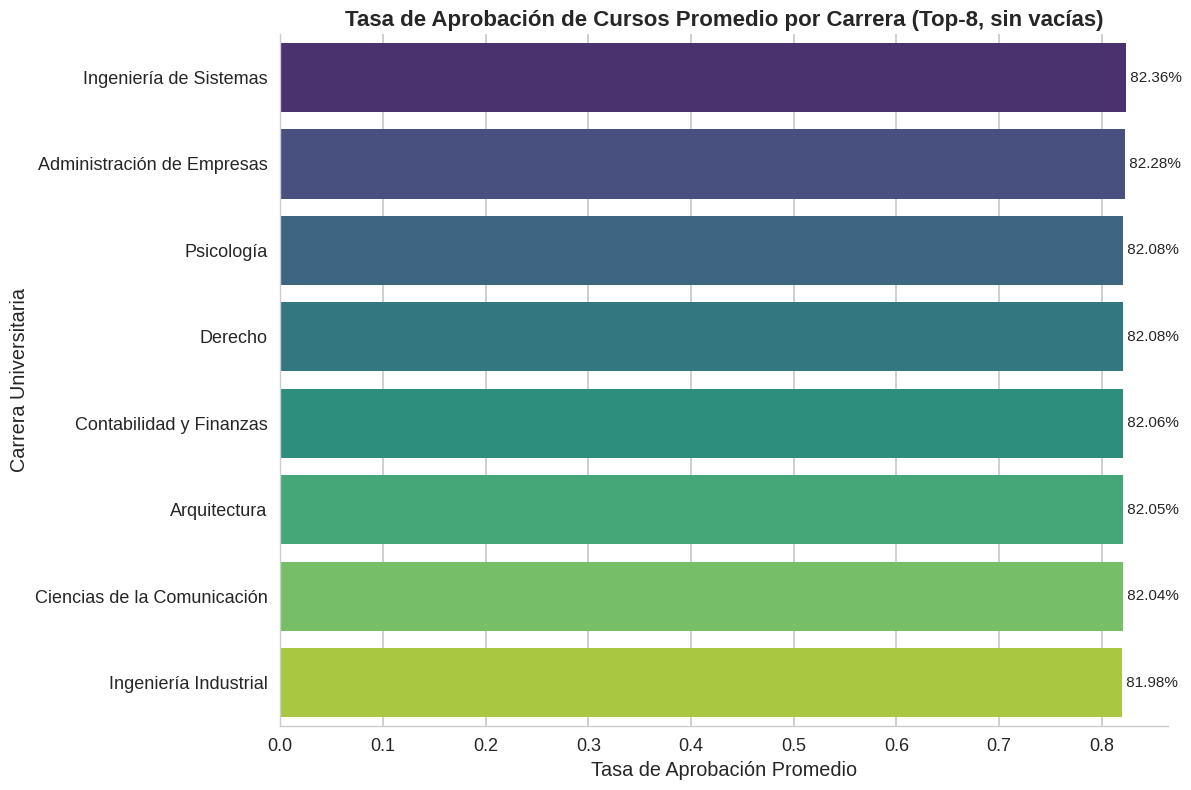

In [ ]:
# 1) columnas numéricas seguras
for c in ["cursosmatriculados","cursosaprobados","creditosmatriculado","creditosaprobadostotal"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 2) tasa de aprobación segura (sin /0) + clip a [0,1]
df["tasa_aprobacion_cursos"] = np.where(
    (df["cursosmatriculados"] > 0) & np.isfinite(df["cursosmatriculados"]),
    df["cursosaprobados"] / df["cursosmatriculados"],
    np.nan
).clip(0, 1)

# 3) candidatos por volumen (toma más de 8 por si hay que filtrar vacías)
top_candidatas = df["estructuraalumno"].value_counts().nlargest(20).index.tolist()
df_top = df[df["estructuraalumno"].isin(top_candidatas)].copy()

# 4) agregado por carrera
analisis_por_carrera = (
    df_top.groupby("estructuraalumno", dropna=False)
          .agg(tasa_aprobacion_cursos_promedio=("tasa_aprobacion_cursos","mean"),
               numero_de_registros=("semestre","count"))
          .reset_index()
)

# 5) filtro CLAVE: elimina barras “vacías” (NaN o 0) y deja TOP-8
analisis_por_carrera = (
    analisis_por_carrera[
        analisis_por_carrera["tasa_aprobacion_cursos_promedio"].fillna(0) > 0
    ]
    .sort_values("tasa_aprobacion_cursos_promedio", ascending=False)
    .head(8)
    .reset_index(drop=True)
)

# 6) etiquetas visibles
def _is_numeric_like(vals):
    s = pd.Series(vals)
    return pd.to_numeric(s, errors="coerce").notna().mean() > 0.8

labels_are_codes = _is_numeric_like(analisis_por_carrera["estructuraalumno"])

# (opcional) si tu columna son códigos y quieres nombres “bonitos”, ponlos aquí (8)
nombres_carreras_8 = [
    'Ingeniería de Sistemas',
    'Administración de Empresas',
    'Psicología',
    'Derecho',
    'Contabilidad y Finanzas',
    'Arquitectura',
    'Ciencias de la Comunicación',
    'Ingeniería Industrial'
]

if labels_are_codes:
    # mapea en el orden actual de la tabla (ya ordenada por tasa)
    mapa = dict(zip(analisis_por_carrera["estructuraalumno"], nombres_carreras_8[:len(analisis_por_carrera)]))
    analisis_por_carrera["label_visible"] = analisis_por_carrera["estructuraalumno"].map(mapa).astype(str)
else:
    analisis_por_carrera["label_visible"] = analisis_por_carrera["estructuraalumno"].astype(str)

# 7) gráfico
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

orden = analisis_por_carrera["label_visible"]
sns.barplot(
    x="tasa_aprobacion_cursos_promedio",
    y="label_visible",
    data=analisis_por_carrera,
    orient="h",
    palette="viridis",
    order=orden
)

ax.set_title("Tasa de Aprobación de Cursos Promedio por Carrera (Top-8, sin vacías)", fontsize=16, weight="bold")
ax.set_xlabel("Tasa de Aprobación Promedio")
ax.set_ylabel("Carrera Universitaria")

# anota porcentajes al final de cada barra
for i, v in enumerate(analisis_por_carrera["tasa_aprobacion_cursos_promedio"]):
    ax.text(v, i, f" {v:.2%}", va="center", ha="left", fontsize=11)

plt.tight_layout()
plt.show()

11. Preparación con num_cols

In [ ]:
# 1) columnas base (usa solo las que existan en df)
feats_base = [
    "cursosmatriculados", "cursosaprobados",
    "creditosmatriculado", "creditosaprobadostotal",
    "promediosemestre", "promedioponderado",
]
feats = [c for c in feats_base if c in df.columns]
assert len(feats) >= 3, "Faltan columnas clave para preparar los datos."

# 2) a numérico + limpieza básica (todo en float32 para bajar RAM)
X_raw = (
    df[feats]
    .apply(pd.to_numeric, errors="coerce")
    .replace([np.inf, -np.inf], np.nan)
    .dropna(how="any")
    .astype("float32")
    .copy()
)

# 3) métricas derivadas (tasas con control por división entre 0) + saneo [0,1]
if {"cursosaprobados", "cursosmatriculados"}.issubset(X_raw.columns):
    den = X_raw["cursosmatriculados"].astype("float32")
    num = X_raw["cursosaprobados"].astype("float32")
    tasa = np.divide(num, den, out=np.full_like(num, np.nan), where=(den > 0))
    X_raw["tasa_cursos"] = np.clip(tasa, 0.0, 1.0)

if {"creditosaprobadostotal", "creditosmatriculado"}.issubset(X_raw.columns):
    den = X_raw["creditosmatriculado"].astype("float32")
    num = X_raw["creditosaprobadostotal"].astype("float32")
    tasa = np.divide(num, den, out=np.full_like(num, np.nan), where=(den > 0))
    # esta tasa no necesariamente está en [0,1], pero clip evita valores extremos por ruido
    X_raw["tasa_creditos"] = np.clip(tasa, 0.0, None)

# quita filas con NaN residuales (p.ej., divisiones inválidas)
X_raw = X_raw.dropna(how="any").astype("float32", copy=False)

# 4) features finales numéricas (incluye tasas si existen)
num_cols = X_raw.columns.tolist()

# 5) split sin fuga + escalado (float32 para RAM)
# si ya existe y_all en el entorno y alinea con X_raw.index, estratifica
_stratify = None
if "y_all" in globals():
    y_all_aligned = y_all.loc[X_raw.index]
    if y_all_aligned.nunique() > 1:
        _stratify = y_all_aligned

X_train, X_test = train_test_split(
    X_raw, test_size=0.20, random_state=42, shuffle=True, stratify=_stratify
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train).astype("float32", copy=False)   # ajusta con TRAIN
X_test_std  = scaler.transform(X_test).astype("float32", copy=False)        # aplica a TEST

# guardo índices útiles para usar luego
X_train_idx = X_train.index
X_test_idx  = X_test.index
idx_all     = X_raw.index  # universo ya depurado

print("Shape train/test:", X_train_std.shape, X_test_std.shape)
print("Features usadas:", num_cols)

Shape train/test: (141390, 8) (35348, 8)
Features usadas: ['cursosmatriculados', 'cursosaprobados', 'creditosmatriculado', 'creditosaprobadostotal', 'promediosemestre', 'promedioponderado', 'tasa_cursos', 'tasa_creditos']


*   **HISTORIA DE USUARIO 04**


**Insight 3**

12. Clustering K-Means

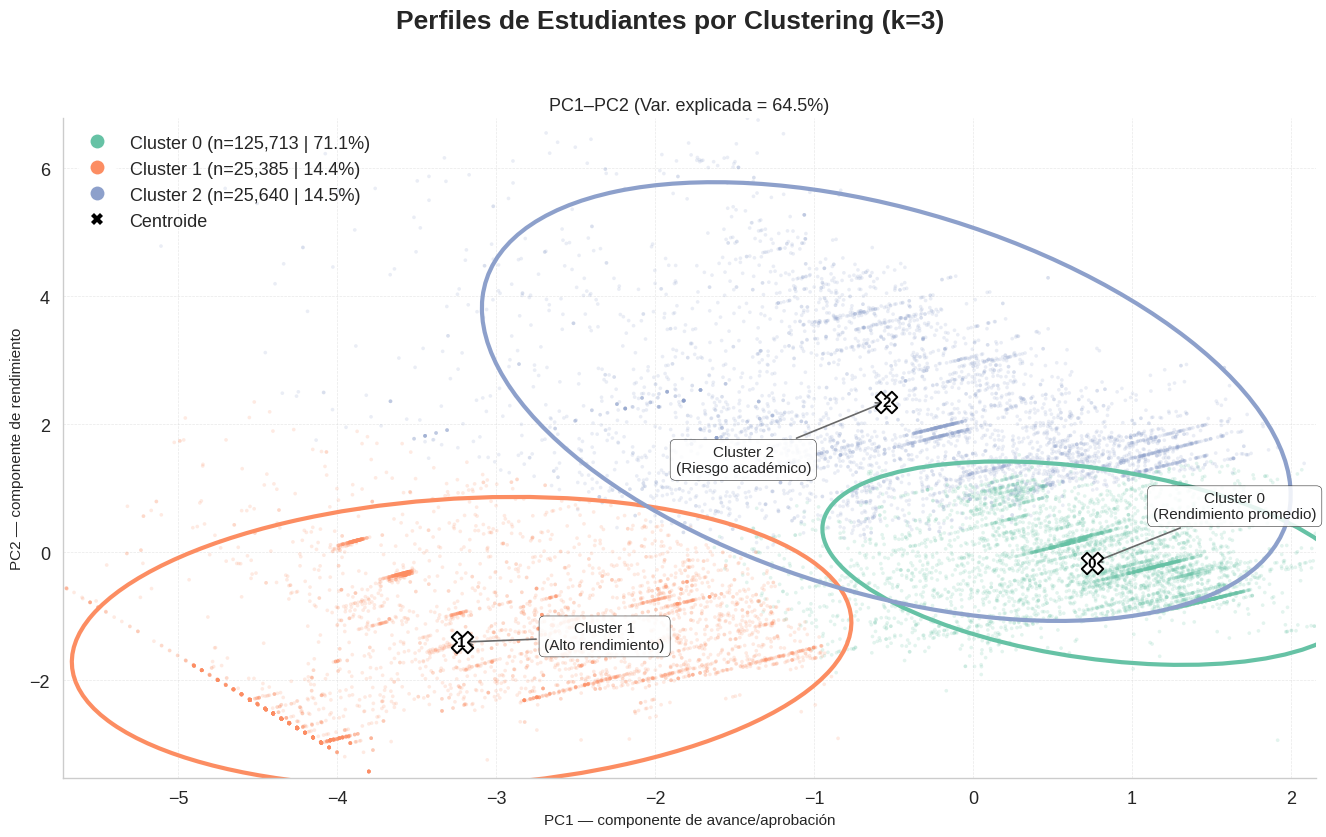

In [ ]:
# --- 0) Guardas y tipos
assert 'scaler' in globals(), "Falta 'scaler' (StandardScaler ya ajustado con TRAIN)."
assert 'X_raw'  in globals(), "Falta 'X_raw' (DataFrame de features sin estandarizar)."
X_raw = X_raw.astype('float32', copy=False)
idx_all = X_raw.index

# --- 1) PCA (sin fuga): ajustar SOLO con TRAIN estandarizado
n_components = int(min(6, X_train_std.shape[1]))  # hasta 6
pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_train_std)

# Proyecta TODO (train+test+otros índices) con el mismo scaler+PCA
Xp_all = pca.transform(
    scaler.transform(X_raw).astype("float32", copy=False)
).astype("float32", copy=False)

# --- 2) K-Means delimitado en PCA (usa PCs iniciales)
k = 3
use_pcs = int(min(4, n_components))  # no más de 4 PCs para k-means
Xp_km = Xp_all[:, :use_pcs].astype('float32', copy=False)

# === Límites solicitados ===
MIN_FIT = 20_000          # mínimo deseado para ajuste
PTS_PER_CLUSTER_PLOT = 5_000
MBK_MAX_ITER = 50

# Limita/garantiza datos para el ajuste del cluster:
# - si hay >= 20k, ajusta con 20k aleatorios
# - si hay < 20k, usa todos (no podemos inventar más)
rng = np.random.default_rng(42)
if len(Xp_km) >= MIN_FIT:
    fit_idx = rng.choice(len(Xp_km), MIN_FIT, replace=False)
else:
    fit_idx = np.arange(len(Xp_km))

# MiniBatchKMeans (rápido y estable) con iter=50
mbk = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    n_init='auto',
    batch_size=4_096,
    max_iter=MBK_MAX_ITER,      # <-- 50 iteraciones
    reassignment_ratio=0.01
)
mbk.fit(Xp_km[fit_idx])
labels_all = mbk.predict(Xp_km)

# Guarda etiquetas en df (crea la columna si no existe)
df.loc[idx_all, "cluster_kmeans_pca"] = labels_all.astype(int)

# --- 3) Datos para plot 2D (PC1 vs PC2) con muestreo fuerte
pc12 = Xp_all[:, :2].astype('float32', copy=False)  # PC1, PC2
plot_df = pd.DataFrame(pc12, columns=["PC1", "PC2"], index=idx_all)
plot_df["cluster"] = labels_all.astype(int)

S_parts = []
for g, sub in plot_df.groupby("cluster", sort=True):
    n = len(sub)
    if n > PTS_PER_CLUSTER_PLOT:
        S_parts.append(sub.sample(PTS_PER_CLUSTER_PLOT, random_state=42))
    else:
        S_parts.append(sub)
S = pd.concat(S_parts, axis=0, ignore_index=False)

# --- 4) Centroides y elipses (90%) calculados sobre la muestra S
centroids = S.groupby("cluster")[["PC1", "PC2"]].mean()
covs = {}
for g in centroids.index:
    pts = S.loc[S["cluster"] == g, ["PC1", "PC2"]].values
    if len(pts) >= 3:
        covs[g] = np.cov(pts.T)
    else:
        covs[g] = np.eye(2, dtype='float32') * 1e-3  # fallback

k2 = float(np.sqrt(chi2.ppf(0.90, df=2)))  # 90% cobertura

def add_cov_ellipse(ax, mean, cov, edgecolor, lw=3.0):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * k2 * np.sqrt(np.maximum(vals, 1e-12))
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                  facecolor="none", edgecolor=edgecolor, lw=lw)
    ax.add_patch(ell)

# --- 5) Plot (ligero)
palette = plt.cm.Set2.colors
colors = {g: palette[g % len(palette)] for g in sorted(centroids.index)}

plt.style.use("seaborn-v0_8-talk")
fig, ax = plt.subplots(figsize=(13.5, 8.5))

# puntos por cluster
for g in sorted(S["cluster"].unique()):
    sub = S[S["cluster"] == g]
    ax.scatter(sub["PC1"], sub["PC2"], s=7, alpha=0.18,
               color=colors[g], edgecolors="none", label=f"Cluster {g}")

# centroides + elipses
for g in centroids.index:
    mu = centroids.loc[g].values
    add_cov_ellipse(ax, mu, covs[g], edgecolor=colors[g], lw=3.0)
    ax.scatter(*mu, s=240, marker="X", c="white", edgecolors="black",
               linewidth=1.4, zorder=5)
    ax.text(mu[0], mu[1], f"{g}", color="black", fontsize=11, weight="bold",
            ha="center", va="center", zorder=6)

# etiquetas interpretativas (ajústalas si cambian tus grupos)
cluster_labels = {
    0: "Cluster 0\n(Rendimiento promedio)",
    1: "Cluster 1\n(Alto rendimiento)",
    2: "Cluster 2\n(Riesgo académico)",
}
offset = {0: ( 0.9,  0.7), 1: ( 0.9, -0.1), 2: (-0.9, -1.1)}
for g in centroids.index:
    mu = centroids.loc[g].values
    dx, dy = offset.get(g, (0.6, 0.6))
    ax.annotate(cluster_labels.get(g, f"Cluster {g}"),
                xy=mu, xytext=(mu[0]+dx, mu[1]+dy),
                arrowprops=dict(arrowstyle="->", lw=1.2, color="dimgray"),
                fontsize=11, ha="center",
                bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85))

# leyenda con tamaños globales (no del muestreo)
sizes = pd.Series(labels_all).value_counts().sort_index()
total_n = int(sizes.sum())
legend_elems = [
    Line2D([0],[0], marker='o', color='w',
           label=f"Cluster {g} (n={int(sizes[g]):,} | {sizes[g]/total_n:.1%})",
           markerfacecolor=colors[g], markersize=10) for g in sizes.index
]
legend_elems.append(
    Line2D([0],[0], marker='X', color='w', label='Centroide',
           markerfacecolor='k', markeredgecolor='k', markersize=9, lw=0)
)
ax.legend(handles=legend_elems, loc="upper left", frameon=False)

# títulos y ejes
var12 = float(pca.explained_variance_ratio_[:2].sum())
fig.suptitle(f"Perfiles de Estudiantes por Clustering (k={k})", fontsize=19, weight="bold")
ax.set_title(f"PC1–PC2 (Var. explicada = {var12:.1%})", fontsize=13, pad=6)
ax.set_xlabel("PC1 — componente de avance/aprobación", fontsize=11)
ax.set_ylabel("PC2 — componente de rendimiento", fontsize=11)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.45)

# zoom automático sin outliers extremos (1–99 percentil)
x1, x2 = S["PC1"].quantile([0.01, 0.99])
y1, y2 = S["PC2"].quantile([0.01, 0.99])
padx = (x2 - x1) * 0.06
pady = (y2 - y1) * 0.06
ax.set_xlim(x1 - padx, x2 + padx)
ax.set_ylim(y1 - pady, y2 + pady)

fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

*   **HISTORIA DE USUARIO 05**

**Insight 4:**

13. Clustering jerárquico y comparación con K-Means

/tmp/ipython-input-2822502865.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  S = plot_all.groupby("km", group_keys=False).apply(_sampler).copy()


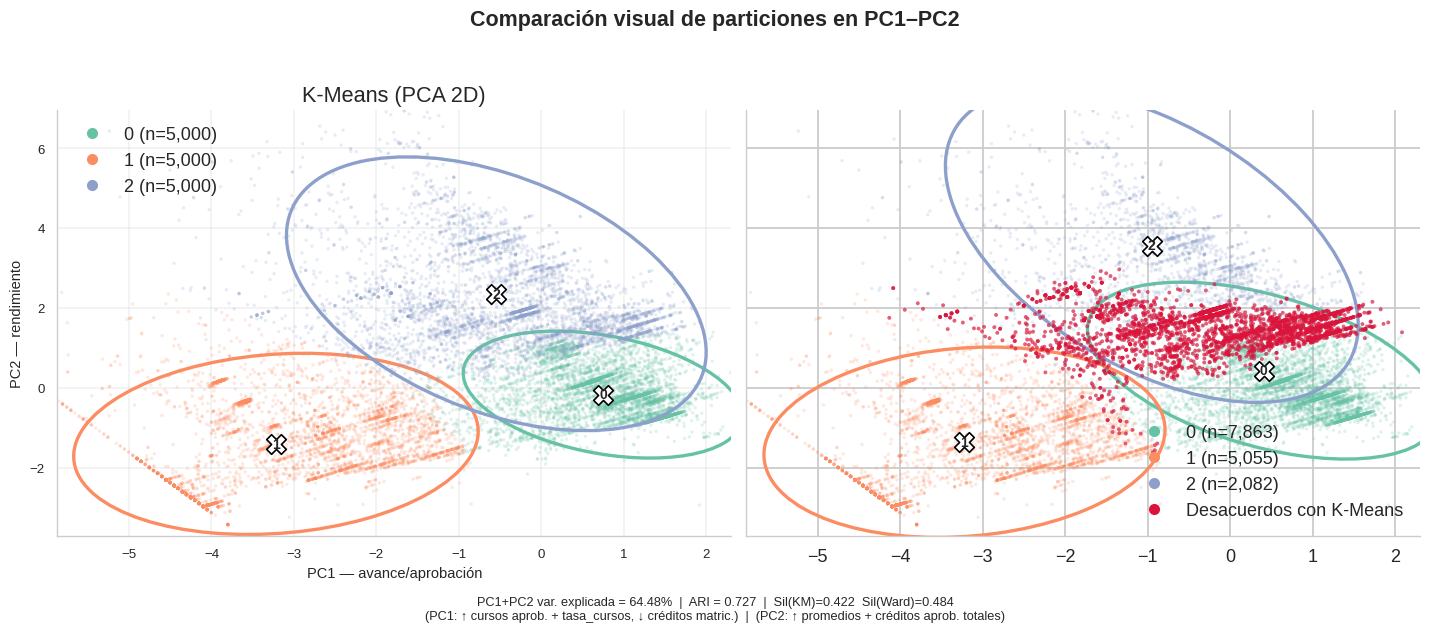

4709

In [ ]:
# --- 0) Guardas y proyección estable ---
assert 'pca' in globals() and 'scaler' in globals(), "Faltan 'pca' y/o 'scaler' ya entrenados."
assert 'X_raw' in globals(), "Falta 'X_raw' (features sin estandarizar)."
idx_all = X_raw.index if 'idx_all' not in globals() else idx_all

Xp_all = pca.transform(scaler.transform(X_raw).astype("float32", copy=False)).astype("float32", copy=False)

labels_km = pd.Series(
    pd.to_numeric(df.loc[idx_all, "cluster_kmeans_pca"], errors="coerce").astype("Int64").values,
    index=idx_all
).fillna(-1).astype(int).values
if (labels_km < 0).any():
    raise ValueError("Faltan etiquetas 'cluster_kmeans_pca' en df para algunos índices.")
k = int(pd.Series(labels_km).nunique())

# === LÍMITES SOLICITADOS ===
SIL_SAMPLE = 20_000          # 20 mil para métricas (silhouette)
MAX_PER_CLUSTER_PLOT = 5_000 # 5 mil puntos por clúster en la figura
WARD_SAMPLE = 5_000          # mantener 5k para Ward (O(n^2) en memoria/tiempo)

# --- 1) Ward en muestra delimitada y propagación por centroides ---
n_sample = int(min(WARD_SAMPLE, len(Xp_all)))
rng = np.random.default_rng(42)
s_idx = rng.choice(len(Xp_all), n_sample, replace=False) if len(Xp_all) > n_sample else np.arange(len(Xp_all))
Xp_s = Xp_all[s_idx]

agg_s = AgglomerativeClustering(n_clusters=k, linkage="ward")
lab_s = agg_s.fit_predict(Xp_s)

C_agg = np.vstack([Xp_s[lab_s == g].mean(axis=0) if (lab_s == g).any()
                   else Xp_s.mean(axis=0) for g in range(k)]).astype("float32", copy=False)
labels_agg = cdist(Xp_all, C_agg).argmin(axis=1).astype(int)
df.loc[idx_all, "cluster_agg_pca"] = labels_agg

# --- 2) Métricas (muestras grandes pero acotadas) ---
sil_ss = int(min(SIL_SAMPLE, len(Xp_all)))   # 20k o todo si hay menos
ari   = adjusted_rand_score(labels_km, labels_agg)
sil_k = silhouette_score(Xp_all, labels_km, sample_size=sil_ss, random_state=42)
sil_a = silhouette_score(Xp_all, labels_agg, sample_size=sil_ss, random_state=42)

# --- 3) Alineación de colores AGG->KM por centroides globales ---
km_u  = np.unique(labels_km)
agg_u = np.unique(labels_agg)
C_km  = np.vstack([Xp_all[labels_km == g].mean(axis=0) for g in km_u]).astype("float32", copy=False)
C_ag  = np.vstack([Xp_all[labels_agg == g].mean(axis=0) for g in agg_u]).astype("float32", copy=False)
map_  = {int(a): int(km_u[i]) for a, i in zip(agg_u, cdist(C_ag, C_km).argmin(axis=1))}
labels_agg_m = np.array([map_.get(int(a), int(a)) for a in labels_agg], dtype=int)
df.loc[idx_all, "cluster_agg_pca_mapped"] = labels_agg_m

# --- 4) DataFrame 2D y muestra balanceada por KM (para plot) ---
PC12 = Xp_all[:, :2].astype("float32", copy=False)
plot_all = pd.DataFrame(PC12, columns=["PC1", "PC2"], index=idx_all)
plot_all["km"]   = labels_km
plot_all["aggM"] = labels_agg_m
plot_all["agree"]= (plot_all["km"] == plot_all["aggM"])

def _sampler(sub):
    n = len(sub)
    return sub.sample(min(n, MAX_PER_CLUSTER_PLOT), random_state=42)

S = plot_all.groupby("km", group_keys=False).apply(_sampler).copy()

# --- 5) Utilitarios: elipse ~90% + centroides ---
k2 = float(np.sqrt(chi2.ppf(0.90, df=2)))

def cov_ellipse(ax, mean, cov, color, lw=2.4):
    vals, vecs = np.linalg.eigh(cov)
    vals = np.maximum(vals, 1e-12)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    w, h = 2 * k2 * np.sqrt(vals)
    ang = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ax.add_patch(Ellipse(xy=mean, width=w, height=h, angle=ang,
                         facecolor="none", edgecolor=color, lw=lw))

def ellipse_group(ax, df2d, lab_col, g, color):
    M = df2d[df2d[lab_col] == g][["PC1", "PC2"]].values
    if len(M) < 3: return
    mu = M.mean(axis=0)
    cov = np.cov(M.T) if len(M) >= 3 else np.eye(2, dtype="float32") * 1e-3
    cov_ellipse(ax, mu, cov, color)
    ax.scatter(*mu, s=200, marker="X", c="white", edgecolors="black",
               linewidth=1.2, zorder=10)
    ax.text(mu[0], mu[1], f"{g}", ha="center", va="center",
            fontsize=10, weight="bold", zorder=11)

palette = plt.cm.Set2.colors
colors = {int(g): palette[int(g) % len(palette)] for g in np.unique(labels_km)}

# --- 6) Figura (dos paneles) ---
xlabel = "PC1 — avance/aprobación"
ylabel = "PC2 — rendimiento"
nota   = "(PC1: ↑ cursos aprob. + tasa_cursos, ↓ créditos matric.)  |  (PC2: ↑ promedios + créditos aprob. totales)"
pc12_var = float(pca.explained_variance_ratio_[:2].sum())

fig, (axL, axR) = plt.subplots(1, 2, figsize=(14.4, 6.3), sharex=True, sharey=True)
fig.suptitle("Comparación visual de particiones en PC1–PC2", fontsize=15.5, weight="bold")

# IZQ: K-Means
for g in sorted(S["km"].unique()):
    sub = S[S["km"] == g]
    axL.scatter(sub["PC1"], sub["PC2"], s=6, alpha=0.20, color=colors[g], edgecolors="none")
    ellipse_group(axL, S, "km", g, colors[g])

n_k = S["km"].value_counts().sort_index()
handles_L = [Line2D([0], [0], marker='o', color='w',
                    label=f"{g} (n={int(n_k[g]):,})",
                    markerfacecolor=colors[g], markersize=8, lw=0)
             for g in sorted(n_k.index)]
axL.legend(handles=handles_L, frameon=False, loc="upper left")
axL.set_title("K-Means (PCA 2D)")
axL.set_xlabel(xlabel, fontsize=10.5); axL.set_ylabel(ylabel, fontsize=10.5)
axL.tick_params(labelsize=9.5); axL.grid(alpha=0.25)

# DER: Ward mapeado + desacuerdos
for g in sorted(S["aggM"].unique()):
    sub = S[S["aggM"] == g]
    axR.scatter(sub["PC1"], sub["PC2"], s=6, alpha=0.20, color=colors[g], edgecolors="none")
    ellipse_group(axR, S.rename(columns={"aggM": "lab"}), "lab", g, colors[g])

no_match = S[~S["agree"]]
if len(no_match):
    axR.scatter(no_match["PC1"], no_match["PC2"], s=8, alpha=0.65,
                color="crimson", edgecolors="none", label="Desacuerdos")

n_ag = S["aggM"].value_counts().sort_index()
handles_R = [Line2D([0], [0], marker='o', color='w',
                    label=f"{g} (n={int(n_ag.get(g, 0)):,})",
                    markerfacecolor=colors[g], markersize=8, lw=0)
             for g in sorted(n_k.index)]
handles_R += [Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson',
                     label="Desacuerdos con K-Means", markersize=8, lw=0)]
axR.legend(handles=handles_R, frameon=False, loc="lower right")

# Límites y pie
x1, x2 = S["PC1"].quantile([0.01, 0.99])
y1, y2 = S["PC2"].quantile([0.01, 0.99])
px, py = (x2 - x1) * 0.08, (y2 - y1) * 0.08
for ax in (axL, axR):
    ax.set_xlim(x1 - px, x2 + px)
    ax.set_ylim(y1 - py, y2 + py)

plt.figtext(0.5, 0.012,
            f"PC1+PC2 var. explicada = {pc12_var:.2%}  |  ARI = {ari:.3f}  |  Sil(KM)={sil_k:.3f}  Sil(Ward)={sil_a:.3f}\n{nota}",
            ha="center", fontsize=9.2)
plt.tight_layout(rect=[0, 0.05, 1, 0.94])
plt.show()

# Limpieza liviana
del Xp_s, C_agg
import gc; gc.collect()

*   **HISTORIA DE USUARIO 06**

**Insight 5:**

14. Regresión logística

In [ ]:
# ---------- 1) Target seguro y alineado ----------
def _safe_ratio(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    r = np.where((b > 0) & np.isfinite(b), a / b, np.nan)
    return pd.Series(r, index=a.index)

# Éxito si tasa de cursos aprobados/matriculados >= 0.80
tasa_total = _safe_ratio(df["cursosaprobados"], df["cursosmatriculados"])
y_all = (tasa_total >= 0.80).astype(int)

# Alinear con índices de features
x_train_idx = X_train.index
x_test_idx  = X_test.index
y_train = y_all.loc[x_train_idx]
y_test  = y_all.loc[x_test_idx]

# ---------- 2) Búsqueda de C por AUC-ROC (5 folds estratificados) ----------
C_grid = np.logspace(-3, 2, 12)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = {}
for C in C_grid:
    lr_cv = LogisticRegression(
        C=C,
        max_iter=50,           # <- reducido
        tol=1e-3,               # <- tolerancia más laxa para converger antes
        class_weight="balanced",
        solver="lbfgs"
    )
    aucs = cross_val_score(
        lr_cv, X_train_std, y_train, scoring="roc_auc", cv=cv, n_jobs=-1  # <- paralelo
    )
    cv_scores[C] = float(np.mean(aucs))

best_C = max(cv_scores, key=cv_scores.get)

# ---------- 3) Entrenamiento final ----------
logreg = LogisticRegression(
    C=best_C,
    max_iter=50,              # <- reducido
    tol=1e-3,
    class_weight="balanced",
    solver="lbfgs"
)
logreg.fit(X_train_std, y_train)

# ---------- 4) Predicciones y umbral óptimo (F1 en test) ----------
proba_test = logreg.predict_proba(X_test_std)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba_test)
f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
thr_opt = float(thr[np.argmax(f1)]) if len(thr) else 0.5
y_pred = (proba_test >= thr_opt).astype(int)

# ---------- 5) Métricas y reporte ----------
auc_cv   = cv_scores[best_C]
auc_test = roc_auc_score(y_test, proba_test)
ap_test  = average_precision_score(y_test, proba_test)  # PR-AUC

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
acc  = (tp + tn) / (tp + tn + fp + fn)
ppv  = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # precision
tpr  = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # recall / sensitivity
tnr  = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # specificity
f1_  = 2 * ppv * tpr / (ppv + tpr + 1e-12)
bacc = (tpr + tnr) / 2

print(f"Mejor C (CV ROC-AUC) : {best_C:.4g}  |  AUC(cv)={auc_cv:.3f}")
print(f"AUC(test)={auc_test:.3f}  |  PR-AUC(test)={ap_test:.3f}  |  Umbral óptimo (F1)={thr_opt:.3f}\n")

print("Métricas puntuales en test:")
print(f"- Accuracy          : {acc:.3f}")
print(f"- Precision (PPV)   : {ppv:.3f}")
print(f"- Recall (TPR)      : {tpr:.3f}")
print(f"- Specificity (TNR) : {tnr:.3f}")
print(f"- F1-score          : {f1_:.3f}")
print(f"- Balanced Accuracy : {bacc:.3f}\n")

print("Reporte de clasificación (test):")
print(classification_report(y_test, y_pred, digits=4))

cm_df = pd.DataFrame(cm, index=["Real 0","Real 1"], columns=["Pred 0","Pred 1"])
print("\nMatriz de confusión (test):")
print(cm_df)

# ---------- 6) Importancia de variables (coeficientes y odds ratio) ----------
n_feat = int(logreg.coef_.shape[1])

# Nombres de columnas
if isinstance(X_train, pd.DataFrame) and X_train.shape[1] == n_feat:
    feat_names = list(X_train.columns)
elif "pca" in globals() and hasattr(pca, "components_") and n_feat <= pca.components_.shape[0]:
    feat_names = [f"PC{i+1}" for i in range(n_feat)]
else:
    feat_names = [f"feat_{i}" for i in range(n_feat)]

coef = pd.Series(logreg.coef_[0], index=feat_names)
odds = np.exp(coef)

# Top positivos/negativos por magnitud
top_pos = coef.sort_values(ascending=False).head(10)
top_neg = coef.sort_values(ascending=True).head(10)

def _fmt_coefs(series):
    lines = []
    for k, v in series.items():
        lines.append(f"{k:<30s} {v:>9.4f}   OR={np.exp(v):>8.3f}")
    return "\n".join(lines)

print("\nTop +coef (mayor prob. de 'éxito'):")
print(_fmt_coefs(top_pos))
print("\nTop -coef (menor prob. de 'éxito'):")
print(_fmt_coefs(top_neg))

Mejor C (CV ROC-AUC) : 0.008111  |  AUC(cv)=1.000
AUC(test)=1.000  |  PR-AUC(test)=1.000  |  Umbral óptimo (F1)=0.454

Métricas puntuales en test:
- Accuracy          : 1.000
- Precision (PPV)   : 1.000
- Recall (TPR)      : 1.000
- Specificity (TNR) : 1.000
- F1-score          : 1.000
- Balanced Accuracy : 1.000

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997      8620
           1     1.0000    0.9999    0.9999     26728

    accuracy                         0.9999     35348
   macro avg     0.9997    0.9999    0.9998     35348
weighted avg     0.9999    0.9999    0.9999     35348


Matriz de confusión (test):
        Pred 0  Pred 1
Real 0    8619       1
Real 1       4   26724

Top +coef (mayor prob. de 'éxito'):
tasa_cursos                       6.2758   OR= 531.550
cursosaprobados                   3.1770   OR=  23.975
creditosmatriculado               0.2702   OR=   1.310
tasa_creditos           

In [ ]:
# Guarda el DataFrame limpio en un archivo CSV
# df.to_csv("/content/Prueba2_dataset.csv", index=False)

# print("Dataset procesado guardado como /content/Prueba2_dataset.csv")

In [ ]:
# Guarda el DataFrame limpio en un archivo Parquet
# df.to_parquet("/content/Prueba2_dataset.parquet", index=False)

# print("Dataset procesado guardado como /content/Prueba2_dataset.parquet")